# TSO Master Class Notebook, part 2 --- Simulating transiting exoplanet observations

The objective of this second part of the "solution" TSO Master Class Notebook is to simulate transiting exoplanet observations in order to find the optimal observational setup (including the instruments) to reach our scientific 
objectives. For this, we will make use of several tools to prepare our observations: from <a id="https://exoctk.stsci.edu/pandexo/">PandExo</a> to generate transiting exoplanet observations and optimize the observational parameters to use in APT, to <a id='https://exoctk.stsci.edu/'>ExoCTK</a>, which will allow us to generate transit spectroscopy models and the <a id='https://jwst.etc.stsci.edu/'>JWST ETC</a> calculator, which will allow us to make sense of the calculations made by those tools. This will leave us on a perfect position to start our APT file for submission. 

**1. Model transmission spectra for K2-18 b**

There are serveral tools out there to simulate transmission spectra of exoplanets. This is needed in our excercise because the tools we are going to use depend on feeding a model to generate simulated data. The ExoCTK has tools to generate model transmission spectra either using the <a id="http://adsabs.harvard.edu/abs/2010ApJ...709.1396F">Fortney et al. 2010</a> grid [<a id="https://exoctk.stsci.edu/fortney">here</a>] or generic scaled models from <a id="https://arxiv.org/abs/1710.10269">Goyal et al. (2018)</a> [<a id="https://exoctk.stsci.edu/generic">here</a>]. Both of these model grids are bounded to tempreatures higher than 400 K (generic) and 500 K (Fortney's grid), however, which will not be useful for us. We have generated a model for K2-18 b scaling the generic grid to match the HST observations [<a id="https://github.com/nespinoza/time_series_masterclass2019/blob/master/data/k218_transpec.dat">here</a>]. We've also compiled the <a id="https://arxiv.org/abs/1909.04642">Benneke et al. (2019)</a> transmission specturm [<a id="https://github.com/nespinoza/time_series_masterclass2019/blob/master/data/k218_data.dat">here</a>]. 

We can plot both the data and the spectrum to check out how they look like:



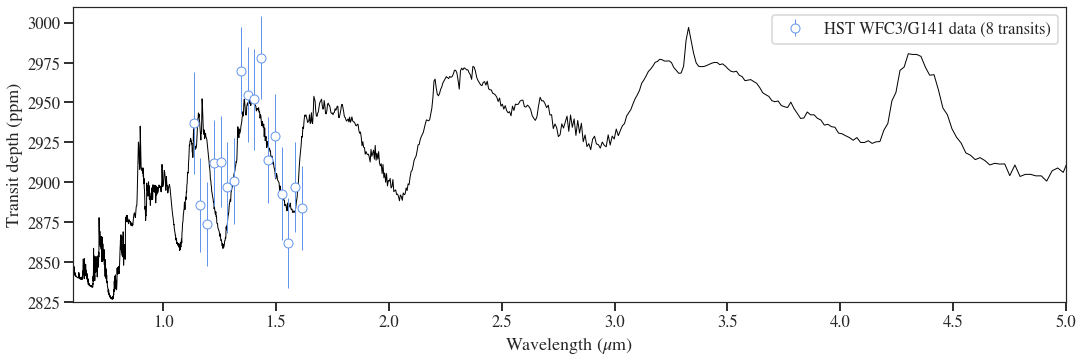

In [3]:
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np

# Get model:
w,d = np.loadtxt('data/k218_transpec.dat',unpack=True)
# Get data; save mean wavelength and mean errors for simplicity of plotting:
wl,wu,ddata,dsu,dsl = np.loadtxt('data/k218_data.dat',unpack=True)
wdata = (wl+wu)/2.
derr = (dsu+dsl)/2.

# Plot data. First some preambles:
plt.figure(figsize=(15,5))
sns.set_context("talk")
sns.set_style("ticks")
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = '5' 
matplotlib.rcParams['axes.linewidth'] = 1.2 
matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'
matplotlib.rcParams['lines.markeredgewidth'] = 1 

# Now plot:
plt.plot(w,d*1e6,color='black',zorder=1,lw=1)
plt.errorbar(wdata,ddata,yerr=derr,fmt='o',mec='cornflowerblue',mfc='white',ecolor='cornflowerblue',\
             elinewidth=1,zorder=2,label = 'HST WFC3/G141 data (8 transits)')
plt.xlim(0.6,5.0)
plt.ylim(2825,3010)
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('Transit depth (ppm)')
plt.legend()
plt.tight_layout()

All the major "bumps" between 1-3 microns are water features! Recovering one or several of those is the objective of our excercise.

**2. Simulating JWST observations for K2-18 b**

We now have a model transmission spectrum to play with. In theory, what we would have to do now is to simulate the lightcurves these models would imply, map that into JWST observed (noisy) spectra, reduce it and try to see what lightcurves (and thus transit depths) we get back by modelling those. Gladly, <a id="https://ui.adsabs.harvard.edu/abs/2017PASP..129f4501B/abstract">Batalha et al. (2017)</a> already wrote a tool to do exactly this: <a id="https://exoctk.stsci.edu/pandexo/">PandExo</a>. Here we will use the online version of this tool, but if several runs are planned, the recommendation is to use the <a id="https://natashabatalha.github.io/PandExo/">installable version</a> in your computer.

Using the online PandExo engine is very intuitive. You can directly resolve the planetary properties by giving the name of your star, which will automatically fill the properties of the star and the transit in the background. Here are the explainations of each of the inputs you need to give to PandExo: 

1. **Name**. This defines an arbitrary name to your calculation.
2. **Star/Planet properties**. Here you can either load the properties given the planet's name or, if not in the database, input the properties of your star/planet yourself.
3. **Stellar model**. The stellar model needed to comput the flux as a function of wavelength observed by JWST. "Get Default From Phoenix" will get the closest Phoenix model for the star --- you can also give your own spectrum of the object.
4. **Planet Model**. Here you can upload your own transmission/emission spectrum model (ours is above!), select one from a grid or, alternatively, you can set "Constant Value", where it is assumed the input model is just a "flat" spectrum.
5. **Baseline**. How much data you want *out of transit*? This is important, because out-of-transit data is very useful for detrending in real observations.
6. **Number of transits**. How many transit events are you going to simulate (this can be changed later!).
7. **Instrument** Name of the instrument you want to simulate observations for.
8. **Number of Groups per Integration** How many groups per integration do you want to define? You can set this to 0 to let PandExo find the optimal number.
8. **Saturation limit** Fraction of full-well capacity or number of electrons that you want to set as the saturation limit (so if optimizing, the constraint would be you don't hit this number!). Reccomendation from JWST ETC is to keep this to <a id="https://jwst-docs.stsci.edu/mid-infrared-instrument/miri-predicted-performance/miri-bright-source-limits#">70%</a> the <a id="https://jwst-docs.stsci.edu/mid-infrared-instrument/miri-instrumentation/miri-detector-overview">full well capacity for MIRI</a>, and 80% this same capacity for <a id="https://jwst-docs.stsci.edu/near-infrared-camera/nircam-predicted-performance/nircam-bright-source-limits">NIRCam</a>, <a id="https://jwst-docs.stsci.edu/near-infrared-spectrograph/nirspec-instrumentation/nirspec-detectors/nirspec-detector-performance">NIRSpec</a> and <a id="https://jwst-docs.stsci.edu/near-infrared-imager-and-slitless-spectrograph/niriss-predicted-performance/niriss-bright-limits">NIRISS</a> if you want to avoid saturation. <font color='red'>However, **there are important caveats** to discuss regarding what actual limits one should choose for time-series observations (e.g., based on experience with HST, we would typically want to hit *half* saturation, not values just below saturation). We discuss them at the end of section 3 below but, for the moment, we will use those numbers just to try PandExo out and learn what it does</font>.

9. **Noise floor** Assumed noise floor for JWST.

From running all the possible instrument setups, it will become evident that the best modes to get the water feature in one shot are NIRISS/SOSS and NIRSpec/Prism. In PandExo, one can download the simulations (useful for proposal writing!) by clicking the "Download Data" button at the bottom of the results page. This will download a pickle file that one can manipulate in python to extract the results of the simulation. In my case, I have renamed that file to a file called ``pandexo_results.p``. We can plot the simulations on top of the plot we already made with the transmission spectrum as follows, where I have chosen to plot the NIRISS/SOSS simulations:

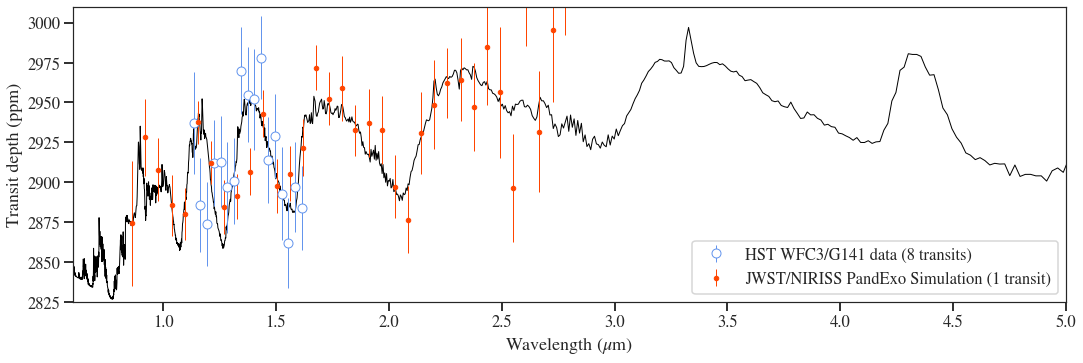

In [105]:
import matplotlib
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def bin_data(x,y,n_bin):
    '''
    This function receives data (in our case, x is wavelnegth, y is the transit depth) and a 
    binning factor n_bin and bins the data to that factor. It returns the binned data.
    '''
    x_bins = []
    y_bins = []
    y_err_bins = []
    for i in range(0,len(x),n_bin):
        x_bins.append(np.median(x[i:i+n_bin-1]))
        y_bins.append(np.median(y[i:i+n_bin-1]))
        y_err_bins.append(np.sqrt(np.var(y[i:i+n_bin-1]))/np.sqrt(len(y[i:i+n_bin-1])))
    return np.array(x_bins),np.array(y_bins),np.array(y_err_bins)

# Get model and data --- this part is exactly the same as the script above:
w,d = np.loadtxt('data/k218_transpec.dat',unpack=True)
wl,wu,ddata,dsu,dsl = np.loadtxt('data/k218_data.dat',unpack=True)
wdata = (wl+wu)/2.
derr = (dsu+dsl)/2.

# Now get PandExo JWST/NIRISS simulation (note the pickle file generated by PandExo can only be opened with Python3):
out = pickle.load(open('data/pandexo_results.p','rb'))
# Extract PandExo simulated spectrum and bin it to 60 pixels:
wbin_pandexo,specbin_pandexo, errbin_pandexo = bin_data(out['FinalSpectrum']['wave'],\
                                                        out['FinalSpectrum']['spectrum_w_rand'], \
                                                        60)

# Plot data. First some preambles:
plt.figure(figsize=(15,5))
sns.set_context("talk")
sns.set_style("ticks")
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = '5'
matplotlib.rcParams['axes.linewidth'] = 1.2
matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'
matplotlib.rcParams['lines.markeredgewidth'] = 1

# Now plot. First HST data:
plt.plot(w,d*1e6,color='black',zorder=1,lw=1)
plt.errorbar(wdata,ddata,yerr=derr,fmt='o',mec='cornflowerblue',mfc='white',ecolor='cornflowerblue',\
             elinewidth=1,zorder=2,label = 'HST WFC3/G141 data (8 transits)')

# Now JWST simulation:
plt.errorbar(wbin_pandexo,specbin_pandexo*1e6,yerr=errbin_pandexo*1e6,fmt='.',color='orangered',ecolor='orangered',\
             elinewidth=1,zorder=2,label = 'JWST/NIRISS PandExo Simulation (1 transit)')

plt.xlim(0.6,5.0)
plt.ylim(2825,3010)
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('Transit depth (ppm)')
plt.legend()
plt.tight_layout()

It is very encouraging to see that the water features will be readily detectable _with only one JWST transit_. In contrast, HST had to take 8 transits to reach the same precision. For these observations, one can either choose SUBSTRIP96 or SUBSTRIP256. The former gives a fastest readout (good for bright targets!), while the latter allows to have more data to correct from possible contamination from light coming from the second order of the spectrum. We will use SUBSTRIP96 here, but be aware that on a real scenario, perhaps choosing SUBSTRIP256 would be better to have more information during the data reduction process.

It is important to note that in reality one would want to run proper model comparison to check whether this model is better than a flat line (one piece of evidence on this front is that a chi-square test assuming a flat line for the JWST/NIRISS simulation gives a very low p-value --- but proper model comparison should be done). <a id="https://exoctk.stsci.edu/atmospheric_retrievals">ExoCTK also has atmospheric retrieval tools</a> with which one can perform model comparison. However, these statistical tests are out of the scope of this MasterClass and we won't touch them here. We encourage, however, users perform proper atmospheric retrievals to ensure that the simulations give rise to the constraints the users want to extract from the data.

**Finally, a very useful output that PandExo provides is APT-ready numbers to input if one sets the runs so they are optimized**. For the case of NIRISS, for example, where I set the saturation level at 56,000 electrons, I see the following information:

![Pandexo APT-ready numbers](img/pandexo_timing.png)

So PandExo predicts that to optimize the observations one should do 14 groups per integration, and a total of 291 integrations out-of-transit and 291 integrations in-transit (so, in practice, a total of 582 integrations in one exposure). Total time per integration (including the reset at the beggining of each integration): 33.21 seconds in our case (this is simply the length of the observations, i.e., the length of an exposure in the JWST jargon --- 5.368950 hours --- divided by the number of integrations). 

**3. Double checking the PandExo Groups and Integrations calculator with the JWST ETC**

A good excercise is to always double check the calculations of every algorithm one uses. In our case, this is useful to do not only from a learning perspective, but we also *need* to do it because (1) we want to be sure our numbers are correct and agree accross different calculators and (2) we need to add an aditional exposure, the Target Acquisition exposure which is mandatory in our case. 

*3.1 Double checking PandExo with the JWST ETC*

The <a id="https://jwst.etc.stsci.edu/">JWST ETC</a> is very intuitive to use, although in our case it will "only" be useful to generate one integration of the several integrations we will want to make for our observations. To do this, we simply create a workbook, load it and start working. The first step is to create what is called an "astronomical scene" for our object. In the "ID" tab we can create a name for this ID. Next, we want to first define how the continuum should look like. We know K2-18 is an MV star, so let's input that in the "Continuum" tab:

![JWST ETC --- Continuum tab values](img/etc_scene_cont.png)

Now, we want to renormalize the SED of this object so it resembles what we see in the sky. For this we can simply give a magnitude, and this will rescale the stellar model to what JWST would really observe. This is done under the "Renorm" tab:

![JWST ETC --- Renorm tab values](img/etc_scene_ren.png)

Then we can jump to the other tabs on the top. In particular, under "Detector Setup" we can input the values for one integration, and any groups we want. If we want to recreate the PandExo calculations, we could give the following here:

![JWST ETC --- Detector Setup tab values matching the PandExo calculations](img/etc_scene_detector.png)

(Note how the exposure time matches almost exactly what PandExo gave in its outputs! This makes sense, as PandExo uses the JWST ETC in the background to perform its calculations). "Instrument Setup" and "Strategy" are not of much use for us with NIRISS/SOSS because the default options are the ones we will be interested in for our science case. The "Backgrounds" option, on the other hand, allows us to set different levels of background which might impact our observations. Note these <a id="https://jwst-docs.stsci.edu/observatory-functionality/jwst-background-model">are assumed as constant sources of background behind your object</a>, so these calculations **are *not* considering possible contaminating sources in your observations (e.g., a nearby star, galaxy, satellite, etc.)**. Still, for faint sources, it is recommended one always checks how the different background levels change our observations, because this implies <a id="https://jwst-docs.stsci.edu/observatory-functionality/jwst-background-model/background-limited-jwst-observations">a special requirement that we have to ask for using a special flag in APT</a>. In our case this is easy, because we already know the dates in which we want to observe and thus can simply input those dates to check how the SNR changes on each epoch due to this background. I have ran calculations doing exactly this for the four dates of interest for us (the four observable transits of K2-18 during Cycle 1), and the results are as follows:

![SNR change with different backgrounds](img/etc_scene_snr.png)

As expected, the SNR change due to the background at different dates is negligible for us (<0.14%)! Our observations have high SNR, and also they are below 5 microns, <a id="https://jwst-docs.stsci.edu/observatory-functionality/jwst-background-model">where the background level really starts to increase</a>. Note that this is calculated at a specific wavelength (for us, this is 1.575 microns by default) --- this can be changed under the "Strategy" tab to any wavelength range of interest.

Interestingly, all the results of the calculation of our frame that you can see under "Images" and "Plots" can be downloaded with the JWST ETC under "Reports" (lower right corner). This downloads a `.tar` file with all the simulations, images, extracted spectrum, etc. of the simulated integration. 

I have downloaded below the images corresponding to calculations made for one of the dates above with and integration composed of groups ranging from 10 to 18, so we can see how these calculations compare with the PandExo predictions/recommendations of using 14 groups to avoid our imposed limit of reaching 56,000 electrons in the frame. Note these images are in electrons per second, so we need to scale them up by the total integration time without counting the reset time (i.e., frame rate x number of groups, with frame rate being equal to 2.214 seconds):

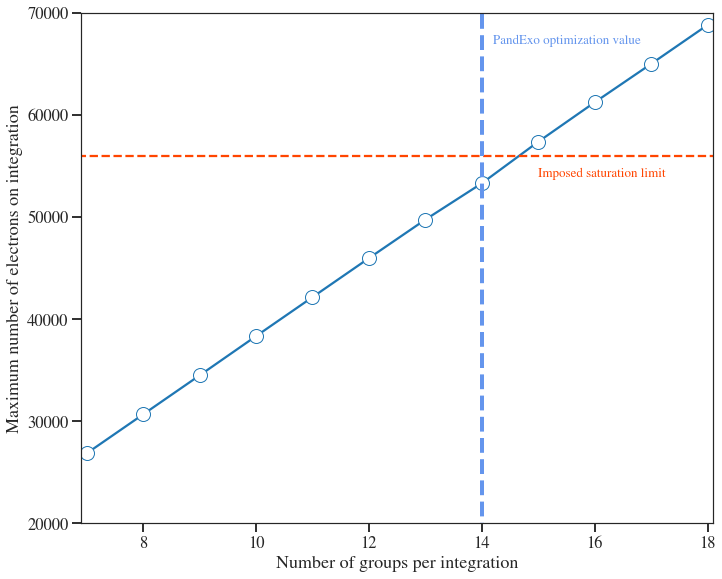

In [10]:
from astropy.io import fits

# Define arrays that will save our data:
ngroups = np.array([])
max_electrons = np.array([])

# Iterate to get the data from the frames:
for i in range(7,19):
    # Get image from the i-th group simulation.
    data = fits.getdata('data/jwst_etc_products/group'+str(i)+'/image/image_detector.fits')
    # Get total integration time (without accounting for reset time --- only accounting 
    # for photon-collecting time):
    t_noreset = i * 2.214
    # Get pixel with the maximum count in the frame --- scale it by the photon-counting time, save 
    # that to our max_electrons array:
    ngroups = np.append(ngroups, i)
    max_electrons = np.append(max_electrons, np.max(data)*t_noreset)

# Now plot. First some preambles:
plt.figure(figsize=(10,8))
sns.set_context("talk")
sns.set_style("ticks")
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = '5'
matplotlib.rcParams['axes.linewidth'] = 1.2
matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'
matplotlib.rcParams['lines.markeredgewidth'] = 1

# Plot data:
plt.plot(ngroups, max_electrons,'o-',mfc ='white',ms=14)

# Plot PandExo limit:
plt.plot([6,19],[56000,56000],'--',color='orangered')
plt.text(15,54000,'Imposed saturation limit',color='orangered',fontsize=13)

# Plot PandExo recommendation:
plt.plot([14,14],[0.,1e5],'--',lw=4,color='cornflowerblue')
plt.text(14.2,67000,'PandExo optimization value',color='cornflowerblue',fontsize=13)

# Labels and limits of plot:
plt.xlabel('Number of groups per integration')
plt.ylabel('Maximum number of electrons on integration')
plt.xlim(6.9,18.1)
plt.ylim(2e4,7e4)
plt.tight_layout()


Indeed, the PandExo recomendation leaves the maximum pixel values below our target maximum value for the saturation limit (56,000 electrons). An integration composed of 15 groups gives a number of electrons just over our limit, and this is why PandExo recommends using 14 groups. This type of calculation is exactly what PandExo does in the background: it checks which of all the combinations of groups gives a total number of electrons per integration _just_ lower than the imposed saturation limit. 

<font color='red'>As a final note, and as highlighted above in the PandExo parameters, however, it is important to briefly discuss that one **would most likely not want** to target electron counts just below saturation for JWST time-series observations based on previous experience with HST/WFC3 (NIR) spectro-photometry</font>. For HST/WFC3, saturation limits where defined in terms of <a id="http://www.stsci.edu/hst/wfc3/documents/ISRs/WFC3-2012-08.pdf">reaching a low ammount of non-linearity</a> in the fluxes measured in the WFC3 pixels/detectors and thus reaching counts too close to this limit *might* lead to decreases in the photometric precision if there are any residual non-linearities in pixels given they are too close to this limit and the typical high photometric precisions one wants to reach for transit spectroscopy. For HST/WFC3, researchers have shown that targeting about 1/2 to 1/3 the saturation level value led to very good results. It would be, thus, conservative to follow the same strategy for JWST observations. 

**For the case of our NIRISS observations, thus, we would like to target a maximum of about 28,000** electrons (which is about half saturation --- 56,000/2 electrons) to be observed in all the detector pixels. From our results above, saturation happens at 15 groups per integration, so to be conservative we could choose 15/2 groups, which would either be 7 or 8 groups per integration. I will choose 8 groups per integration which gives a little bit more than 30,000 electrons on a given integration. According to the JWST ETC, this implies a total integration time (including resets) of 19.95 seconds --- to cover the full 5.368950 hours of the observation that we defined above, we would thus need 

$\frac{\left(5.368950\ \textrm{hours}\right) \times \left(3600\ \textrm{seconds/hour}\right)}{19.95\ \textrm{seconds/integration}} \approx 969\ \textrm{integrations}$ 

to cover those 5.368950 hours. We can input those numbers (a run with 8 groups and 969 integrations) in PandExo directly on a final run to see how our transmission spectrum should look like --- the interested reader can check that the overall precision is more or less the same we obtained with a larger number of groups. 

*3.2 Generating Target Acquisition simulations with JWST ETC*

Let us **now generate/simulate the Target Acquisition (TA) exposure with the JWST ETC**. First of all, note the TA is <a id="https://jwst-docs.stsci.edu/methods-and-roadmaps/jwst-time-series-observations/niriss-specific-time-series-observations"> very important (in fact, mandatory for us as we will be using SUBSTRIP96) to ensure that the target falls on the detector</a>, and thus is a critical exposure to be careful about when planning a JWST observation. To generate a TA exposure for NIRISS, simply select from the NIRISS drop-down menu "Target Acquisition" --- this will generate a calculation for a TA exposure.

For NIRISS/SOSS, the Instrument Setup only allow us to select Acquisition Modes between "SOSS or AMI Faint" and "SOSS or AMI Bright". Selecting any of those modes depends <a id = "https://jwst-docs.stsci.edu/methods-and-roadmaps/jwst-time-series-observations/target-acquisition-for-time-series-observations">on the brigthness of the target that we will use as the TA object</a>. In our case, we will be using the same target star (K2-18) as the TA object: given the brightness limit for SOSS Faint is $V=8.1$ and for the SOSS Bright mode is $V=3$, and that in our case <a id = "http://simbad.u-strasbg.fr/simbad/sim-basic?Ident=K2-18+&submit=SIMBAD+search">K2-18 has $V=13.5$</a>, we can select **"SOSS or AMI Faint" here**. The Instrument Setup tab would then look like as follows:


![Instrument Setup of JWST ETC for TA of K2-18](img/etc_ta_1.png)

We now switch to the **Detector Setup** tab. Here we don't have any options for the "Subarray" (it is always SOSS or AMI TA). For the "Readout pattern", in our case we can choose between NIS and NISRAPID. <a id = "https://jwst-docs.stsci.edu/near-infrared-imager-and-slitless-spectrograph/niriss-instrumentation/niriss-detector/niriss-detector-readout-patterns">NISRAPID is generally recommended for integrations per exposure that are small (typically bright targets), like it will be most likely in our case</a>, so we can go ahead and select this one. Only one TA integration and exposure is needed, so the only thing we have to worry about is the number of groups. Note that the groups go in odd numbers from 3 to 19 --- this is demanded by the TA observing program scripts. So we have to select an optimal number from this range. The recommendation is to achieve *at least* as signal-to-noise of 30, but the better the SNR, the better the centroiding accuracy and thus the target placement. If one tries any number of groups, one can actually see that the "Maximum number of groups before saturation" is 26 --- so we can go ahead and try 19 groups to get the maximum SNR for our TA exposure. Note the exposure time is only 1 second, which is a negligible ammount of time considering the full science observation exposures --- this in turn allows us to get a SNR of 440, which is great for our purposes:

![Instrument Setup of JWST ETC for TA of K2-18](img/etc_ta_2.png)

**4. What about imaging?**

So far, we have focused on spectroscopic time-series observations of our target. However, if our objective is to simply *detect* the water feature observed by HST, imaging in appropiate filters to perform precise photometric measurements might also be a good strategy. In particular, <a id="https://jwst-docs.stsci.edu/methods-and-roadmaps/jwst-time-series-observations/time-series-observations-roadmap">imaging time-series observations are currently supported by both MIRI and NIRCam</a>, the former providing observations at long-wavelengths ($\lambda > 5 \mu m$), whereas the the latter allows to reach to smaller wavelengths ($\lambda < 5 \mu m$). Because in this case we are interested in the water features at small wavelengths, the instrument to go would be <a id="https://jwst-docs.stsci.edu/near-infrared-camera/nircam-observing-modes/nircam-time-series-observations/nircam-time-series-imaging">NIRCam</a>.

A very nice feature of NIRCam time-series observations that is specially useful for transiting exoplanet observations is that it has a beam splitting dichroic. This splits the light into short ($0.6-2.3\mu m$) and long ($2.3-5.0\mu m$) wavelength channels, so one is able to get data of the same source in two wavelength ranges in one shot. In fact, when using NIRCam in spectroscopic mode (as we did above with PandExo), one is actually using a grism in the long wavelength channel --- light still goes to the short wavelength channel which allows one to obtain simultaneous photometry in that channel while getting spectroscopic observations in the long wavelength channel. Here we will touch only on the first of those possibilities, as that one covers the second one as a special case.

*4.1 Simultaneous two-band photometry with NIRCam: filters* 

Let's start focusing on obtaining precise photometry in both channels, in order to understand how imaging works in practice for precise transit observations (for more details on both modes, <a id="https://jwst-docs.stsci.edu/methods-and-roadmaps/jwst-time-series-observations/nircam-specific-time-series-observations">check out the JWST Documentation page</a>). To this end, let's first plot the filters that can be used in the short and long wavelength channels (<a id="https://jwst-docs.stsci.edu/near-infrared-camera/nircam-instrumentation/nircam-filters">which I have taken from the JWST documentation</a>) along with our model transmission spectrum above to check which ones might be useful for our specific science case:

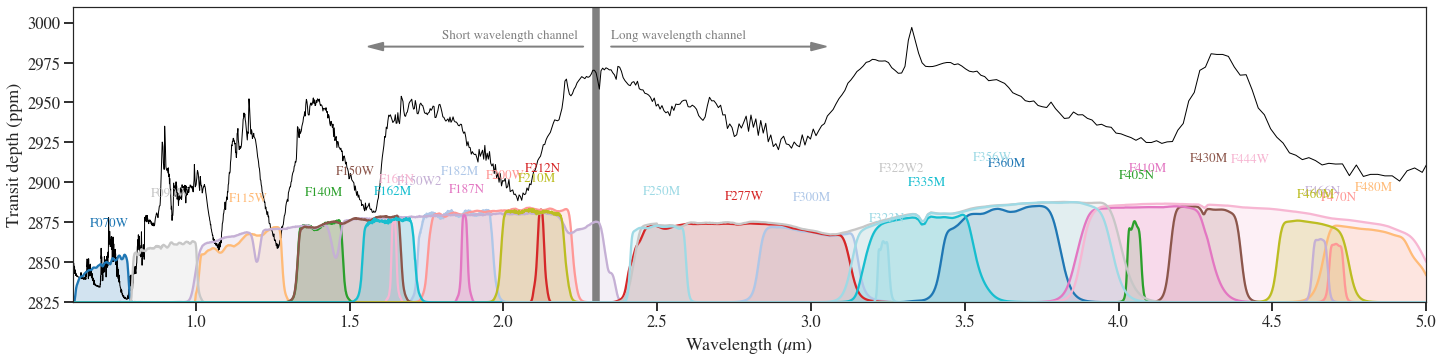

In [149]:
# Plot data. First some preambles:
plt.figure(figsize=(20,5))
sns.set_context("talk")
sns.set_style("ticks")
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = '5' 
matplotlib.rcParams['axes.linewidth'] = 1.2 
matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'
matplotlib.rcParams['lines.markeredgewidth'] = 1 

# Plot model transmission spectrum:
plt.plot(w,d*1e6,color='black',zorder=1,lw=1)

# Now plot filters on top --- below we will set the y-axis between 2825 and 3010 (ppm), so make sure the filter 
# shapes are scaled to those ranges. First, get filenames for the filters:
import glob
sw_filters = glob.glob('data/nircam_filters/sw/*')
n_sw_filters = np.double(len(sw_filters))
lw_filters = glob.glob('data/nircam_filters/lw/*')
n_lw_filters = np.double(len(lw_filters))
# Iterate through them, scaling them to the y-axis limits: multiply first by 3010, then add 2825. First for short 
# wavelength filters, then long wavelength filters:
for filters in [sw_filters,lw_filters]:
    counter = 0
    for f in filters:
        ww,rr = np.loadtxt(f,unpack=True,usecols=(0,1),skiprows = 1)
        # Get (weighted by the response) mean filter wavelength:
        mean_wavelength = np.sum(ww*rr)/np.sum(rr)
        # Filter name:
        filter_name = f.split('/')[-1].split('.txt')[0]
        # Stretch and shift response function. Perform a small, random scaling of the
        rr = (rr*120) + 2825.
        # Extract a color from the tab20 colormap to plot:
        color = plt.cm.tab20(counter/n_sw_filters)
        # Plot response, fill area under curve:
        plt.plot(ww,rr,color=color)
        plt.fill_between(ww,rr,2825,color=color,alpha=0.2)
        # Put name of the filter above the plot. Perform a random scatter of the filter names as to prevent 
        # text overlap:
        plt.text(mean_wavelength-0.05,np.max(rr)+10+np.random.uniform(2,20.),filter_name,color=color,fontsize=13)
        counter += 1

# Plot dividing line between short and long wavelength channels:
plt.fill_between([2.29,2.31],0,10000,color='grey')
plt.arrow(2.35,2985,0.65,0,color='grey',head_width=5, head_length=0.05)
plt.text(2.35,2990,'Long wavelength channel',color='grey',fontsize=13)
plt.arrow(2.26,2985,-0.65,0,color='grey',head_width=5, head_length=0.05)
plt.text(1.8,2990,'Short wavelength channel',color='grey',fontsize=13)
                       
plt.xlim(0.6,5)
plt.ylim(2825,3010)
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('Transit depth (ppm)')
plt.tight_layout()

It is a bit of a mess, but there is a handful of promising observations one might do. Notice how there are some filters that *just* fall into or out of water absorption features (e.g., F140M, F162M, F182M, F210M) --- these are, actually, by design like this. In this particular case, we would like to hopefully get a measurement of at least one point inside and one point outside of a water feature to confirm that, indeed, what HST observed was water. The alternative hypothesis in this case is that the spectrum is featureless (i.e., a flat line). 

After looking carefully at the plot, a promising way of detecting a water feature with NIRCam photometry would be to try to get photometry with the F210M filter in the short wavelength channel simultaneously with photometry with the F250M filter in the long wavelength channel. These two points in the transmission spectrum would look like the following:

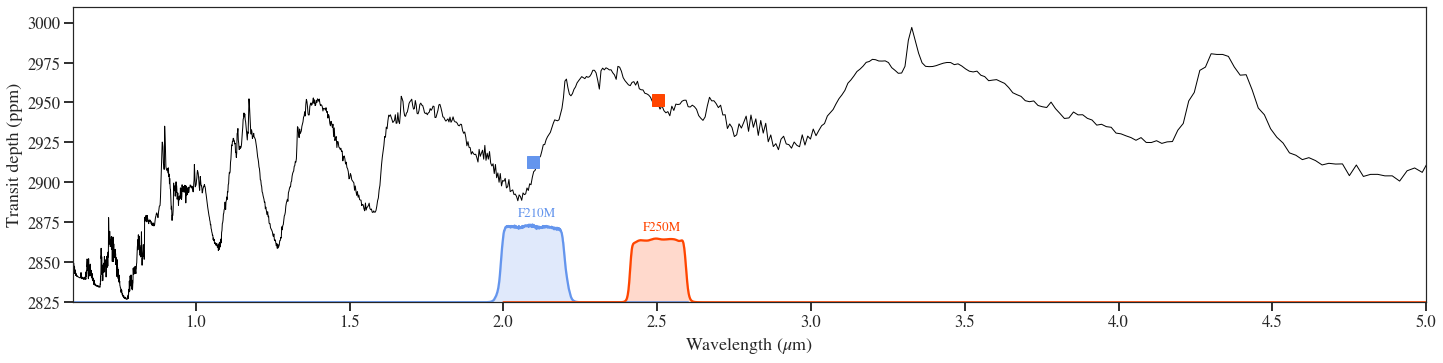

In [148]:
from scipy import interpolate

def get_depth(wts,dts,wrf,rf):
    """
    Given a transmission spectrum defined by the transit depths dts and wavelenghts wts and 
    a filter response function defined by the wavelengths wrf and throughput rf at those wavelengths, 
    this function returns the expected observed transit depth in that given filter.
    """
    # Interpolate the transmission spectrum:
    f = interpolate.interp1d(wts, dts)
    # Evaluate it at the response function wavelengths:
    rf_interp = f(wrf)
    # Evaluate weighted mean between these interpolated values 
    # and the response function:
    return np.sum(rf_interp*rf)/np.sum(rf)
    

# Plot data. First some preambles:
plt.figure(figsize=(20,5))
sns.set_context("talk")
sns.set_style("ticks")
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = '5' 
matplotlib.rcParams['axes.linewidth'] = 1.2 
matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'
matplotlib.rcParams['lines.markeredgewidth'] = 1 

# Plot model transmission spectrum:
plt.plot(w,d*1e6,color='black',zorder=1,lw=1)

# Plot filters, and points in the transmission spectrum:
counter = 0
colors = ['cornflowerblue','orangered']
for f in ['data/nircam_filters/sw/F210M.txt','data/nircam_filters/lw/F250M.txt']:
    ww,rr = np.loadtxt(f,unpack=True,usecols=(0,1),skiprows = 1)
    # Get (weighted by the response) mean filter wavelength:
    mean_wavelength = np.sum(ww*rr)/np.sum(rr)
    depth = get_depth(w,d,ww,rr)*1e6
    # Filter name:
    filter_name = f.split('/')[-1].split('.txt')[0]
    # Stretch and shift response function. Perform a small, random scaling of the
    rr = (rr*100) + 2825.
    # Extract a color from the tab20 colormap to plot:
    color = colors[counter]
    # Plot response, fill area under curve:
    plt.plot(ww,rr,color=color)
    plt.fill_between(ww,rr,2825,color=color,alpha=0.2)
    # Put name of the filter above the plot. Perform a random scatter of the filter names as to prevent 
    # text overlap:
    plt.text(mean_wavelength-0.05,np.max(rr)+5,filter_name,color=color,fontsize=13)
    # Plot transit depth weighted by the response function:
    plt.plot([mean_wavelength],[depth],'s',color=color,ms=12)
    counter += 1
plt.xlim(0.6,5)
plt.ylim(2825,3010)
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('Transit depth (ppm)')
plt.tight_layout()

A featureless spectrum would give rise to both channels giving the same transit depth whereas, as seen above, if water is present in the abundance observed by HST, we should observe a transit depth difference of about 40 ppm between the observations made with these two filters. What photometric precision can we achieve with NIRCam in those filters for K2-18b? Is this measurable? Let's use the JWST ETC to find this out.

*4.2 Simultaneous two-band photometry with NIRCam: simulations with the JWST ETC*

Sadly, PandExo only works for spectrophotometry which means that for photometry, one has to rely on the JWST ETC --- this means there will not be any automatic optimization and thus we have to find the optimal parameters (groups, integrations, subarrays) for our observations ourselves. The good news is that from our experience above, we already understand how to use the JWST ETC and thus can use it at will to figure out our path in this particular case. 

We can use the same scene we used in Section 3.2 above for our NIRCam simulations. In this case, however, we will have to run the simulations between the short and long wavelength channels separately. Let's start by going to the JWST ETC and initiating a new calculation with ``nircam sw_ts`` (i.e., NIRCam short-wavelength time-series). In the Instrument Setup window, we will observe the following options that we can define:

![JWST ETC NIRCam short-wavelength time-series observations options](img/etc_nircam_sw1.png)

The **"LW Pairing"** option allows us to define what we want to do with the long-wavelength light. We can select either imaging (our case) or grism (which will be reviewed later) time-series. For the current case, we select "LW Imaging Time Series". The **"SW Pupil"** allows us to select what to do with the pupil wheel for the short-wavelength observations. In general, <a id="https://jwst-docs.stsci.edu/near-infrared-camera/nircam-instrumentation/nircam-pupil-and-filter-wheels">the F164N and F162M optical elements in the pupil heavily restrict what filters can be used for science</a>, and we won't be using those here. The WLP8 optical element is a <a id="https://jwst-docs.stsci.edu/near-infrared-camera/nircam-instrumentation/nircam-weak-lenses">weak lens</a>, which is used to defocus the short-wavelength image, which is useful to beat saturation and noise limits limits. It is also useful because the integration times for both the long and short wavelength channels have to be identical, and thus for simultaneous photometry in the short-wavelength channel and grism (spectroscopic) observations in the long wavelength channel this is essential to keep similar SNRs between both channels. We will use the "CLEAR" option in our case. Finally, in **"SW Filter"**, we select the filter we decided to use: the F210M filter.

Next up we have to define the Detector Setup:

![JWST ETC NIRCam short-wavelength time-series observations Detector Setup](img/etc_nircam_sw2.png)

To fully understand each of the options, a good read is the whole <a id="https://jwst-docs.stsci.edu/near-infrared-camera/nircam-instrumentation/nircam-detectors">NIRCam detector section in the JWST Documentation</a>. In our case, we want to read frames as fast as possible to avoid saturation, so we select the ``SUB64P`` subarray (which is the smaller one and thus the one that gives the fastest readout) and the ``RAPID`` readout pattern. You can select any number of groups you want until you find the one that avoids saturation --- this "optimal" number of groups is also calculated by the JWST ETC when running a calculation in the "Reports" panel, which recommends a "Maximum Number of Groups Before Saturation" of 2. So we select that number (note this is a bit of a red flag for this idea --- we are probably going to reach counts just before saturation, so as per our discussion above on the saturation limits where we usually would want to target *a fraction* of the saturation level, we could be in trouble in terms of hitting some levels of non-linearity). The results look like this:

![JWST ETC NIRCam short-wavelength time-series observations results](img/etc_nircam_sw3.png)

The precision attained per second in our case is 7998.48/3108276.57 = 2573 ppm, which is pretty good for our purposes! This implies a precision per minute of about 300 ppm. If we assume a box-shaped transit, the precision in the transit depth will be given by 

$\sigma_{\delta} \approx \sigma_P \sqrt{\frac{1}{N_{out}} + \frac{1}{N_{in}}}$

where $\sigma_P$ is the photometric precision, $N_{out}$ is the number of out-of-transit datapoints and $N_{in}$ are the number of in-transit datapoints. With a transit duration of $0.14$ days and assuming a 1-minute cadence, this implies $N_{in} \approx 200$ --- assuming $N_{in} = N_{out}$ this gives a transit depth precision of about 30 ppm. The same calculation for the long-wavelength channel with the JWST ETC using the F250M filter gives a precision per second of 4454.08/986137.25 = 4517 ppm, which implies a precision per minute of about 580 ppm and thus a transit depth precision of about 58 ppm. It appears, then, that imaging in two bands simultaneously is not a very good strategy, as the errors on the transit depths are of the same order as the differences implied by the transmission spectrum model (which is about 40 ppm). On top of this, we are also very close to saturation --- so overall, we would probably dump this particular idea all together as not feasible.
